## Imports

In [1]:
# Deep learning 
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from classification_models.tfkeras import Classifiers
from keras.callbacks import EarlyStopping


# Evaluation
from sklearn.metrics import confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import numpy as np
import pandas as pd
from glob import glob

## Data Preprocessing

In [2]:
train_path = 'car-damage-dataset/data1a/training'
test_path = 'car-damage-dataset/data1a/validation'

In [3]:
image_files = glob(train_path + '/*/*.jp*g')
test_files = glob(test_path + '/*/*.jp*g')

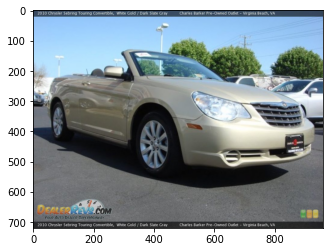

In [4]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## Baseline VGG19 pretrained model

### Image augmentation and normalization

In [5]:
gen = ImageDataGenerator(rescale=1./255)

In [6]:
test_gen = gen.flow_from_directory(test_path, target_size=(224,224))
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 460 images belonging to 2 classes.
{'00-damage': 0, '01-whole': 1}


min: 0.0 max 1.0


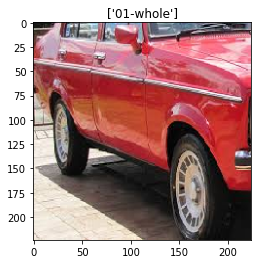

In [7]:
for x,y in test_gen:
    print("min:",x[0].min(),"max",x[0].max())
    plt.title([labels[np.argmax(y[0])]])
    plt.imshow(x[0])
    plt.show()
    break

In [8]:
train_gen = gen.flow_from_directory(train_path, target_size=(224,224))

Found 1840 images belonging to 2 classes.


### Model development

In [9]:
vgg = VGG19(include_top=False,input_shape=[224,224,3])

In [10]:
for layer in vgg.layers:
    layer.trainable = False

In [11]:
x = Flatten()(vgg.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(2,activation='softmax')(x)

In [12]:
model = Model(inputs=vgg.input, outputs=prediction)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model.compile('adam','binary_crossentropy',metrics=['accuracy'])


In [15]:
batch_size = 128

r = model.fit_generator(train_gen,validation_data=test_gen,
                        epochs=20, steps_per_epoch=len(image_files)//batch_size,
                        validation_steps=len(test_files)//batch_size)

Epoch 1/20


C:\Users\Firas\AppData\Local\Temp\ipykernel_14048\4164076424.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(train_gen,validation_data=test_gen,


14/14 [==============================] - 6s 170ms/step - loss: 1.4822 - accuracy: 0.6004 - val_loss: 0.7778 - val_accuracy: 0.5625
Epoch 2/20
14/14 [==============================] - 2s 159ms/step - loss: 0.5571 - accuracy: 0.7455 - val_loss: 0.3852 - val_accuracy: 0.8646
Epoch 3/20
14/14 [==============================] - 2s 154ms/step - loss: 0.3939 - accuracy: 0.8304 - val_loss: 0.2656 - val_accuracy: 0.9062
Epoch 4/20
14/14 [==============================] - 3s 227ms/step - loss: 0.3749 - accuracy: 0.8287 - val_loss: 0.2803 - val_accuracy: 0.9271
Epoch 5/20
14/14 [==============================] - 2s 153ms/step - loss: 0.3759 - accuracy: 0.8527 - val_loss: 0.3066 - val_accuracy: 0.8958
Epoch 6/20
14/14 [==============================] - 2s 155ms/step - loss: 0.3049 - accuracy: 0.8839 - val_loss: 0.2399 - val_accuracy: 0.9167
Epoch 7/20
14/14 [==============================] - 2s 153ms/step - loss: 0.3344 - accuracy: 0.8661 - val_loss: 0.3469 - val_accuracy: 0.8021
Epoch 8/20
14/14 

### Model Evaluation

In [16]:
model.evaluate(test_gen)

15/15 [==============================] - 3s 180ms/step - loss: 0.2287 - accuracy: 0.9087


[0.228682279586792, 0.908695638179779]

In [17]:
model.evaluate(train_gen)

58/58 [==============================] - 7s 120ms/step - loss: 0.0962 - accuracy: 0.9712


[0.09619537740945816, 0.971195638179779]

In [18]:
def get_confusion_matrix(data_path, N, model, target_size):
    print('generating confusion_matrix')
    predictions = []
    targets = []
    for x,y in gen.flow_from_directory(data_path, target_size=target_size,shuffle=False):
        p = model.predict(x)
        p = np.argmax(p, axis = 1)
        y = np.argmax(y, axis = 1)
        predictions = np.concatenate((predictions,p))
        targets = np.concatenate((targets, y))
        if len(targets)>=N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm

In [19]:
cm = get_confusion_matrix(train_path, len(image_files), model, (224,224))
print(cm)

generating confusion_matrix
Found 1840 images belonging to 2 classes.
[[903  17]
 [ 36 884]]


In [20]:
valid_cm = get_confusion_matrix(test_path, len(test_files), model, (224,224))
print(valid_cm)

generating confusion_matrix
Found 460 images belonging to 2 classes.
[[215  15]
 [ 27 203]]


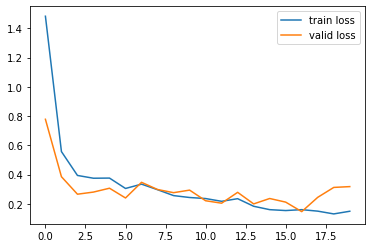

In [21]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'valid loss')
plt.legend()
plt.show()

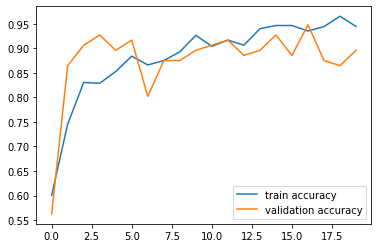

In [22]:
plt.plot(r.history['accuracy'], label = 'train accuracy')
plt.plot(r.history['val_accuracy'], label ='validation accuracy')
plt.legend()
plt.show()

## ResNeXt pretrained model

### Image augmentation and normalization

In [23]:
gen = ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)

In [24]:
test_gen = gen.flow_from_directory(test_path, target_size=(256,256))
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 460 images belonging to 2 classes.
{'00-damage': 0, '01-whole': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -2.0312772 max 2.068272


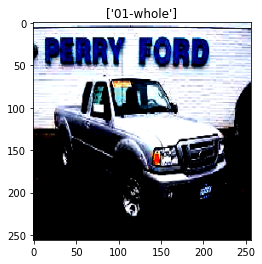

In [25]:
for x,y in test_gen:
    print("min:",x[0].min(),"max",x[0].max())
    plt.title([labels[np.argmax(y[0])]])
    plt.imshow(x[0])
    plt.show()
    break

In [26]:
train_gen = gen.flow_from_directory(train_path, target_size=(256,256))

Found 1840 images belonging to 2 classes.


### Model development

In [27]:
ResNeXt50, preprocess_input = Classifiers.get('resnext50')
resnext = ResNeXt50(include_top = False, input_shape=(256, 256, 3), weights='imagenet')

In [28]:
for layer in resnext.layers[:-6]:
    layer.trainable = False

for layer in resnext.layers[-6:]:
    layer.trainable = True

In [29]:
x = Flatten()(resnext.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(2,activation='softmax')(x)

In [30]:
model_resnext = Model(inputs=resnext.input, outputs=prediction)

In [31]:


model_resnext.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'],
    )

In [32]:

batch_size = 32

r_resnext = model_resnext.fit(train_gen,validation_data=test_gen,
                        epochs=10, steps_per_epoch=len(image_files)//batch_size,
                        validation_steps=len(test_files)//batch_size,
                        callbacks=EarlyStopping(monitor='val_loss', verbose=1, patience=20))

Epoch 1/10
57/57 [==============================] - 27s 288ms/step - loss: 1.1750 - accuracy: 0.5747 - val_loss: 0.6863 - val_accuracy: 0.6496
Epoch 2/10
57/57 [==============================] - 13s 219ms/step - loss: 0.6297 - accuracy: 0.6792 - val_loss: 0.6758 - val_accuracy: 0.5603
Epoch 3/10
57/57 [==============================] - 13s 220ms/step - loss: 0.5678 - accuracy: 0.7246 - val_loss: 0.5557 - val_accuracy: 0.7009
Epoch 4/10
57/57 [==============================] - 13s 220ms/step - loss: 0.4925 - accuracy: 0.7627 - val_loss: 0.5314 - val_accuracy: 0.7076
Epoch 5/10
57/57 [==============================] - 13s 220ms/step - loss: 0.4734 - accuracy: 0.7865 - val_loss: 0.4648 - val_accuracy: 0.7701
Epoch 6/10
57/57 [==============================] - 12s 216ms/step - loss: 0.4311 - accuracy: 0.8075 - val_loss: 0.4224 - val_accuracy: 0.8058
Epoch 7/10
57/57 [==============================] - 12s 216ms/step - loss: 0.4145 - accuracy: 0.8064 - val_loss: 0.6449 - val_accuracy: 0.7522

### Model Evaluation

In [33]:
model_resnext.evaluate(train_gen)

58/58 [==============================] - 10s 165ms/step - loss: 0.2417 - accuracy: 0.9011


[0.24173006415367126, 0.9010869860649109]

In [34]:
model_resnext.evaluate(test_gen)

15/15 [==============================] - 3s 196ms/step - loss: 0.4436 - accuracy: 0.8283


[0.4435650706291199, 0.8282608985900879]

generating confusion_matrix
Found 1840 images belonging to 2 classes.


<AxesSubplot:>

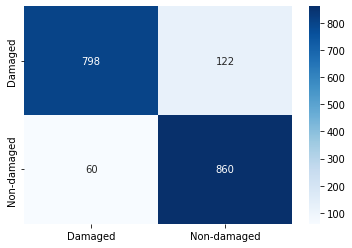

In [35]:
cm = get_confusion_matrix(train_path, len(image_files), model_resnext, (256, 256))

df_cm = pd.DataFrame(
    cm,
    index = ['Damaged', 'Non-damaged'],
    columns = ['Damaged', 'Non-damaged']
)

sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

generating confusion_matrix
Found 460 images belonging to 2 classes.
[[174  56]
 [ 23 207]]


<AxesSubplot:>

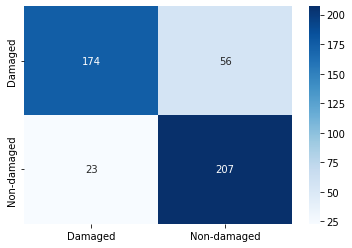

In [36]:
valid_cm = get_confusion_matrix(test_path, len(test_files), model_resnext, (256, 256))
print(valid_cm)

df_valid_cm = pd.DataFrame(
    valid_cm,
    index = ['Damaged', 'Non-damaged'],
    columns = ['Damaged', 'Non-damaged']
)

sns.heatmap(df_valid_cm, annot=True, fmt='g', cmap='Blues')

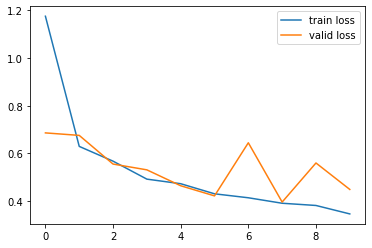

In [37]:
plt.plot(r_resnext.history['loss'],label = 'train loss')
plt.plot(r_resnext.history['val_loss'],label = 'valid loss')
plt.legend()
plt.show()

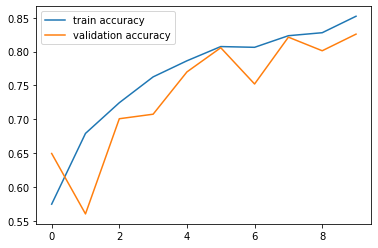

In [38]:
plt.plot(r_resnext.history['accuracy'], label = 'train accuracy')
plt.plot(r_resnext.history['val_accuracy'], label ='validation accuracy')
plt.legend()
plt.show()

In [39]:
# Saving the best model

# model_resnext.save('resnext_50_transfer_learning.h5')